# 03_feature_engineering_correlation.ipynb

# Importando as bibliotecas necessárias

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind # Para testes de hipótese

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# --- 1. Carregamento do Dataset Processado ---
### Carrega o dataset 'cleaned_data.csv' salvo na fase MEASURE.
### Ajuste o caminho conforme a sua estrutura local ou onde o notebook está sendo executado.

In [12]:
url = 'https://raw.githubusercontent.com/moises-rb/projeto_futebol_preditivo/refs/heads/main/02_measure/data/processed/cleaned_data.csv'
try:
    df = pd.read_csv(url)
    print(f"\nDataset 'cleaned_data.csv' carregado com sucesso!")
    print("Primeiras 5 linhas do dataset:")
    print(df.head())
    print("\nInformações básicas do dataset:")
    df.info()
except FileNotFoundError:
    print(f"\nErro: O arquivo 'cleaned_data.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está no caminho correto.")
    print("Você pode precisar executar o notebook '02_eda_data_cleaning.ipynb' primeiro para gerar este arquivo.")


Dataset 'cleaned_data.csv' carregado com sucesso!
Primeiras 5 linhas do dataset:
         date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1  1873-03-08   England  Scotland           4           2   Friendly   London   
2  1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3  1875-03-06   England  Scotland           2           2   Friendly   London   
4  1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral    result  
0  Scotland    False      Draw  
1   England    False  Home Win  
2  Scotland    False  Home Win  
3   England    False      Draw  
4  Scotland    False  Home Win  

Informações básicas do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48335 entries, 0 to 48334
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date  

In [13]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,Home Win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Home Win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Home Win


# --- 2. Engenharia de Features Avançada ---

In [31]:
# Convertendo a coluna 'date' para o formato datetime
df['date'] = pd.to_datetime(df['date'])

# Criando features baseadas na data
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek # Segunda-feira=0, Domingo=6

In [32]:
# Criando feature de vantagem de jogar em casa (já temos 'neutral', mas podemos criar um 'is_home_game')
# is_home_game é 1 se o time da casa não está em campo neutro, 0 caso contrário
df['is_home_game'] = df.apply(lambda row: 1 if row['neutral'] == False else 0, axis=1)

In [33]:
# Feature: Diferença de gols (já criada na fase anterior, mas garantindo que exista)
df['goal_difference'] = df['home_score'] - df['away_score']

In [34]:
# Feature: Total de gols no jogo
df['total_goals'] = df['home_score'] + df['away_score']

# --- Features de Desempenho Histórico (Forma Recente) ---
Esta é uma feature mais complexa e pode exigir um pré-processamento cuidadoso para evitar "data leakage" (usar informações futuras para prever o passado).
Para simplificar, vamos criar uma versão básica que calcula a média de gols marcados e sofridos por cada equipe em seus jogos anteriores.
Isso é um pouco mais avançado e pode ser demorado para datasets grandes.
Vamos focar em um exemplo mais simples de forma inicial.

Para calcular a forma recente, precisaríamos de um histórico de jogos para cada time ANTES de cada partida.
Isso geralmente é feito com loops ou funções mais complexas que ordenam por data.
Por enquanto, vamos omitir o cálculo de "forma recente" complexa para manter o foco nas correlações básicas e evitar a complexidade de "data leakage" neste primeiro passo.
Podemos revisitar isso na fase de engenharia de features mais aprofundada ou na modelagem.

# --- 3. Análise de Correlação ---

In [19]:
# Para a análise de correlação, precisamos converter a variável 'result' em numérica.
# Vamos mapear 'Home Win' para 1, 'Draw' para 0, e 'Away Win' para -1.
# Isso é uma simplificação para correlação linear, mas nos dá uma ideia inicial.
# Para modelos de classificação, usaremos a codificação One-Hot ou Label Encoding.
result_mapping = {'Home Win': 1, 'Draw': 0, 'Away Win': -1}
df['result_numeric'] = df['result'].map(result_mapping)

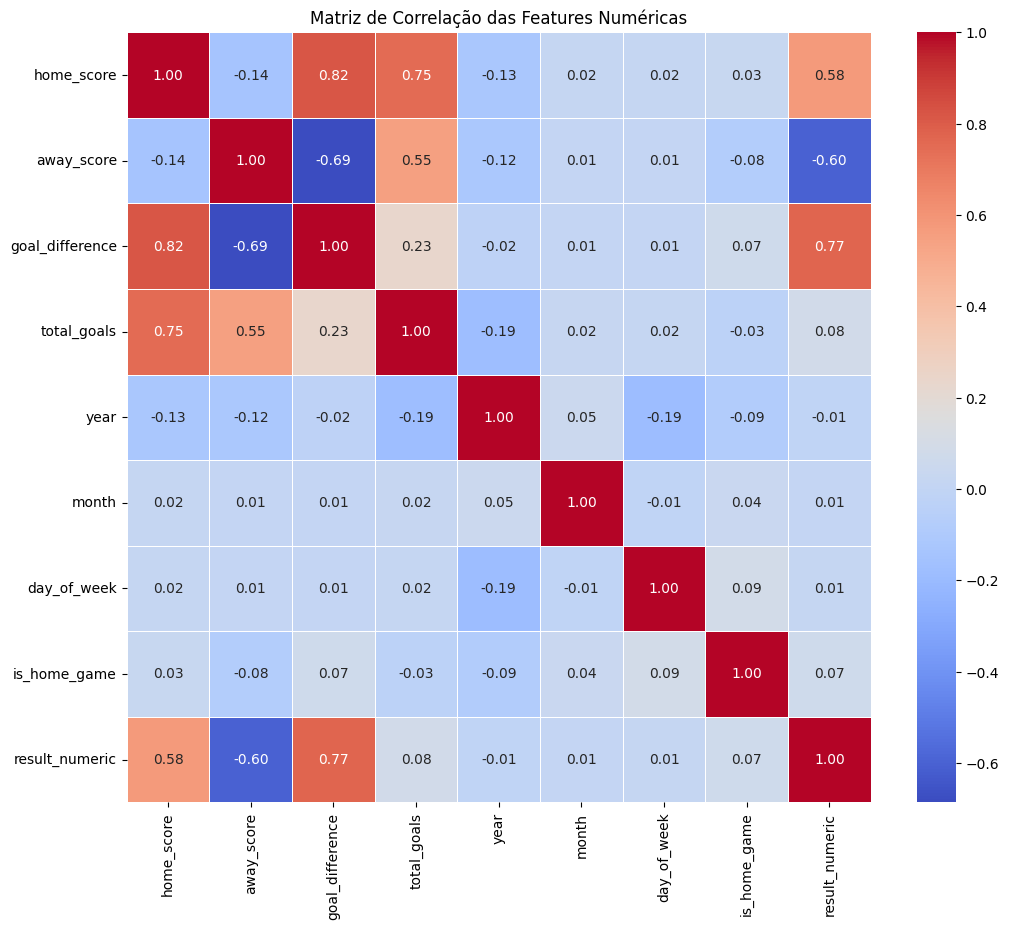


Correlação das features com o resultado numérico (result_numeric):
result_numeric     1.000000
goal_difference    0.774409
home_score         0.576477
total_goals        0.084145
is_home_game       0.069460
day_of_week        0.013200
month              0.010361
year              -0.008228
away_score        -0.604207
Name: result_numeric, dtype: float64


In [20]:
# Selecionando features numéricas para a matriz de correlação
numerical_features = ['home_score', 'away_score', 'goal_difference', 'total_goals', 'year', 'month', 'day_of_week', 'is_home_game', 'result_numeric']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Features Numéricas')
plt.show()

print("\nCorrelação das features com o resultado numérico (result_numeric):")
print(correlation_matrix['result_numeric'].sort_values(ascending=False))

# --- 4. Testes de Hipótese (Exemplo: Mando de Campo) ---

In [21]:
# Vamos testar se há uma diferença significativa na média de gols marcados
# quando o time joga em casa (is_home_game = 1) versus quando não joga (is_home_game = 0).

# Gols marcados pelo time da casa em jogos não neutros
home_goals_non_neutral = df[(df['is_home_game'] == 1)]['home_score']
# Gols marcados pelo time visitante em jogos não neutros (aqui, o 'away_score' é o gol do time visitante)
away_goals_non_neutral = df[(df['is_home_game'] == 0)]['away_score']

In [22]:
# Para uma comparação mais direta sobre "vantagem de jogar em casa",
# podemos comparar a média de gols do time da casa (home_score) em jogos em casa,
# com a média de gols do time visitante (away_score) em jogos fora.
# Ou, de forma mais robusta, comparar a média de gols do time da casa com a média de gols do time visitante em geral.

# Vamos comparar a média de gols marcados pelo time da casa vs. time visitante em TODOS os jogos.
# Isso nos dá uma ideia geral se jogar em casa tende a resultar em mais gols.
t_stat_goals, p_value_goals = ttest_ind(df['home_score'], df['away_score'])

In [23]:
print(f"\nMédia de Gols do Time da Casa: {df['home_score'].mean():.2f}")
print(f"Média de Gols do Time Visitante: {df['away_score'].mean():.2f}")
print(f"Estatística T (comparação de gols): {t_stat_goals:.2f}")
print(f"Valor P (comparação de gols): {p_value_goals:.3f}")

if p_value_goals < 0.05:
    print("Há uma diferença estatisticamente significativa na média de gols entre times da casa e visitantes.")
else:
    print("Não há uma diferença estatisticamente significativa na média de gols entre times da casa e visitantes.")


Média de Gols do Time da Casa: 1.76
Média de Gols do Time Visitante: 1.18
Estatística T (comparação de gols): 56.17
Valor P (comparação de gols): 0.000
Há uma diferença estatisticamente significativa na média de gols entre times da casa e visitantes.


In [25]:
# Teste de hipótese para a proporção de vitórias em casa vs. fora
# Podemos analisar a proporção de 'Home Win' quando 'is_home_game' é 1 vs. 0 (o que é trivial, já que 'Home Win' é por definição quando o time da casa ganha).
# Um teste mais interessante seria comparar a taxa de vitórias do time da casa em jogos não neutros
# versus a taxa de vitórias do time visitante em jogos não neutros.

# Para simplificar, vamos ver as proporções de vitórias em casa/fora/empate
print("\nProporção de Vitórias em Casa, Fora e Empates:")
home_wins_ratio = df[df['result'] == 'Home Win'].shape[0] / df.shape[0]
away_wins_ratio = df[df['result'] == 'Away Win'].shape[0] / df.shape[0]
draw_ratio = df[df['result'] == 'Draw'].shape[0] / df.shape[0]

print(f"Proporção de Vitórias do Time da Casa: {home_wins_ratio:.2%}")
print(f"Proporção de Vitórias do Time Visitante: {away_wins_ratio:.2%}")
print(f"Proporção de Empates: {draw_ratio:.2%}")


Proporção de Vitórias em Casa, Fora e Empates:
Proporção de Vitórias do Time da Casa: 49.04%
Proporção de Vitórias do Time Visitante: 28.22%
Proporção de Empates: 22.74%


In [26]:
# --- Salvar o dataset com as novas features para a próxima fase ---
output_dir = '../data/processed/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Diretório '{output_dir}' criado com sucesso.")

output_path_analyzed = os.path.join(output_dir, 'analyzed_data.csv')
df.to_csv(output_path_analyzed, index=False)
print(f"\nDataset com features avançadas salvo em: {output_path_analyzed}")

print("\nFase ANALYZE (Engenharia de Features e Correlação) concluída neste notebook.")
print("Pronto para aprofundar na Melhoria (Fase IMPROVE)!")

Diretório '../data/processed/' criado com sucesso.

Dataset com features avançadas salvo em: ../data/processed/analyzed_data.csv

Fase ANALYZE (Engenharia de Features e Correlação) concluída neste notebook.
Pronto para aprofundar na Melhoria (Fase IMPROVE)!
